# Read the files

In [1]:
library("tidyverse")
library("janitor")
library("caret")
library("mlr")
library("parallelMap")
library("ggthemr")

ggthemr("fresh")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”

In [2]:
df_train = readRDS("df_train_after_03FE.RData")
df_val = readRDS("df_val_after_03FE.RData")
cols_with_low_iv_values = readRDS("cols_with_low_iv_values.RData")
cols_with_woe_added = readRDS("cols_with_woe_added.RData")

In [3]:
cols_with_low_iv_values %>% cat(sep = " \n ")

nbrhud_comm_180d_violation_cnt 
 zone_type 
 mos_species 
 ses_lt_hs_pct_tract2017 
 loc_lat_lng_src 
 nbrhud_blk_grp_180d_violation_cnt 
 nbrhud_zipcode_180d_violation_cnt 
 t_day_of_yr 
 trap_trap_type 
 mos_salinarius_num_mosquitos 
 mos_unspecified_num_mosquitos 
 mos_erraticus_num_mosquitos 
 mos_tarsalis_num_mosquitos 
 trap_satellite_ind 
 t_day 
 mos_territans_num_mosquitos 
 nbrhud_comm_180d_vacancies_cnt 
 wea_ohare_tavg2_ma7 
 nbrhud_blk_grp_180d_vacancies_cnt 
 nbrhud_zipcode_180d_vacancies_cnt 
 wea_ohare_prcp 
 googtrend_deadbirds 
 wea_ohare_prcp_sum7 
 mos_restuans_num_mosquitos 
 wea_ohare_tavg2_ma60_lag21 
 wea_ohare_tmax 
 wea_ohare_prcp_sum60_lag7


# Little cleanup

In [4]:
# Remove cols_with_low_iv_values to make life a bit simplier

#df_train = df_train %>% select(-cols_with_low_iv_values)
#df_val = df_val %>% select(-cols_with_low_iv_values)

In [5]:
df_train = df_train %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)
df_val = df_val %>% 
    rename(y=mos_any_wnv_present) %>%
    mutate(y = factor(y,levels = c(0,1), labels = c("Clean","Infected"))) %>%
                         select(-loc_census_block_group_id,
                                -loc_census_tract_id,
                                -loc_community,
                                -trap_trap_name)

In [6]:
stopifnot(df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x))) == 
              df_val %>% select_if(is.factor) %>% map_int(~length(levels(.x))))

## Remove NA rows from val set

In [7]:
df_val = df_val[complete.cases(df_val),]

## Make y the 1st col

In [8]:
make_resp_first_var = function(df){
    pred_cols = names(df %>% select(-y))
    df %>% select(y, pred_cols)
}

In [9]:
df_train = df_train %>% make_resp_first_var
df_val   = df_val   %>% make_resp_first_var

In [10]:
dim(df_train)

[1] 15257    64

In [11]:
dim(df_val)

[1] 5903   64

In [12]:
predictors = df_train %>% select(-y) %>% names

Number of levels of all factor vars:

In [13]:
df_train %>% select_if(is.factor) %>% map_int(~length(levels(.x)))

y             t_mo            t_qtr t_day_of_wk_name 
               2                6                3                5 
 loc_lat_lng_src      loc_zipcode       zone_class        zone_type 
               2               47               38                7 
  trap_trap_type      mos_species 
               4                8

## Putting train & val data together

Since `mlr` can handle these data together (much easier) using either holdout, or 5-fold CV, I'm putting these two sets together again.

In [14]:
df_model = df_train %>% bind_rows(df_val)

In [15]:
dim(df_model)

[1] 21160    64

In [16]:
cat("Holdout % : ", round(nrow(df_train)/nrow(df_model),3))

Holdout % :  0.721

# Model Setup

## Preprocess Data

wnv = createDummyFeatures(df_model,target = "y")
wnv = removeConstantFeatures(wnv)

dim(wnv)

glimpse(wnv)

Creating data with **NO** mosquito variables - like mos species count, or mos species information 

In [17]:
df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% distinct()
#wnv_no_mos = createDummyFeatures(df_model_no_mos,target = "y")
#wnv_no_mos = removeConstantFeatures(wnv_no_mos)

Creating data with **NO** species variables but including the mos species count

In [18]:
#df_model_no_mos = df_model %>% select(-starts_with("mos"),-woe_mos_species) %>% 
#    bind_cols(df_model["mos_tot_num_mosquitos"]) %>% distinct()
wnv_mos_count = createDummyFeatures(df_model_no_mos,target = "y")
wnv_mos_count = removeConstantFeatures(wnv_mos_count)

Removing 2 columns: zone_class.PMD.2,trap_trap_type.SENTINEL


In [19]:
dim(wnv_mos_count)

[1] 11583   155

In [20]:
glimpse(wnv_mos_count)

Observations: 11,583
Variables: 155
$ y                                 <fct> Clean, Clean, Clean, Clean, Clean...
$ t_day                             <int> 29, 29, 29, 29, 29, 29, 29, 29, 2...
$ t_wk                              <int> 22, 22, 22, 22, 22, 22, 22, 22, 2...
$ t_day_of_yr                       <int> 149, 149, 149, 149, 149, 149, 149...
$ t_day_of_wk                       <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...
$ t_eval_day                        <int> 514, 514, 514, 514, 514, 514, 514...
$ t_eval_wk                         <int> 74, 74, 74, 74, 74, 74, 74, 74, 7...
$ loc_lat                           <dbl> 41.95630, 41.99549, 41.97418, 41....
$ loc_lng                           <dbl> -87.79752, -87.76961, -87.82524, ...
$ trap_satellite_ind                <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ ses_lt_hs_pct_blk_grp2017         <dbl> 17.4209547, 4.8346056, 3.5010941,...
$ ses_median_hh_inc_blk_grp2017     <int> 39643, 84073, 101101, 91094, 3823...
$ ses_lt_pov_pct

## Create Classification Task & Split

tsk = makeClassifTask(data = wnv, target = "y", positive = "Infected")
tsk

tsk_no_mos = makeClassifTask(data = wnv_no_mos, target = "y", positive = "Infected")
tsk_no_mos

In [21]:
tsk_mos_count = makeClassifTask(data = wnv_mos_count, target = "y", positive = "Infected")
tsk_mos_count

Supervised task: wnv_mos_count
Type: classif
Target: y
Observations: 11583
Features:
   numerics     factors     ordered functionals 
        154           0           0           0 
Missings: FALSE
Has weights: FALSE
Has blocking: FALSE
Has coordinates: FALSE
Classes: 2
   Clean Infected 
   10284     1299 
Positive class: Infected

# Feature Importance

fv = generateFilterValuesData(tsk, method = "anova.test")
fv

options(repr.plot.width=7, repr.plot.height=3.5)
plotFilterValues(fv) + 
    labs(title="Anova Test Result for WNV Training Data", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

fv = generateFilterValuesData(tsk, method = c("randomForest.importance"))
fv

plotFilterValues(fv,facet.wrap.nrow = 2) + 
    labs(title="Random Forest Importance Plot", subtitle="Top Features out of 172 Features") + 
    theme(axis.text.x = element_text(angle = 90)) + 
    coord_flip()

## Build the model

In [22]:
### rdesc = makeResampleDesc("Holdout", stratify = FALSE, split = 0.721)
rdesc = makeResampleDesc("CV", stratify = TRUE, iters = 3)

lrns = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob"),
            makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob"),
            makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=25),
            makeLearner(id = "adaboost", cl = "classif.adaboostm1", predict.type = "prob"),
            makeLearner(id = "cforest", cl = "classif.cforest", predict.type = "prob"),
            makeLearner(id = "C50", cl = "classif.C50", predict.type = "prob"),
            makeLearner(id = "gbm", cl = "classif.gbm", predict.type = "prob"),
            makeLearner(id = "dbnDNN", cl = "classif.dbnDNN", predict.type = "prob"),
            makeLearner(id = "svm", cl = "classif.svm", predict.type = "prob"),
            makeLearner(id = "svm_radial", cl = "classif.svm", predict.type = "prob", kernel = "radial"),
            makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 25))

#makePreprocWrapperCaret(makeLearner(id = "eTrees_norm","classif.evtree",predict.type = "prob"), ppc.center = TRUE, ppc.scale = TRUE)

In [23]:
costs = matrix(c(0, 1, 4, 0), 2)
colnames(costs) = rownames(costs) = c("Infected","Clean")
costs

,Infected,Clean
Infected,0,4
Clean,1,0


In [24]:
th = costs[2,1]/(costs[2,1] + costs[1,2])
th

[1] 0.2

In [25]:
wnv.costs = makeCostMeasure(id = "wnv.costs", name = "WNV costs", costs = costs, best = 0, worst = 4)
wnv.costs

Name: WNV costs
Performance measure: wnv.costs
Properties: classif,classif.multi,req.pred,req.truth,predtype.response,predtype.prob
Minimize: TRUE
Best: 0; Worst: 4
Aggregated by: test.mean
Arguments: costs=<matrix>, combine=<function>
Note: 

In [26]:
meas = list(auc, mmce, f1, tpr, fpr, fnr, ppv, wnv.costs)
meas

[[1]]
Name: Area under the curve
Performance measure: auc
Properties: classif,req.pred,req.truth,req.prob
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Integral over the graph that results from computing fpr and tpr for many different thresholds.

[[2]]
Name: Mean misclassification error
Performance measure: mmce
Properties: classif,classif.multi,req.pred,req.truth
Minimize: TRUE
Best: 0; Worst: 1
Aggregated by: test.mean
Arguments: 
Note: Defined as: mean(response != truth)

[[3]]
Name: F1 measure
Performance measure: f1
Properties: classif,req.pred,req.truth
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Defined as: 2 * tp/ (sum(truth == positive) + sum(response == positive))

[[4]]
Name: True positive rate
Performance measure: tpr
Properties: classif,req.pred,req.truth
Minimize: FALSE
Best: 1; Worst: 0
Aggregated by: test.mean
Arguments: 
Note: Percentage of correctly classified observations in the positive class. Also cal

bmr = readRDS('large_cache/bmr_001.RData')
#parallelStartSocket(cpus = 39)
#bmr = benchmark(learners = lrns, tasks = tsk, resamplings = rdesc, measures = meas, show.info = TRUE)
#parallelStop()

In [27]:
lrn_list = list(makeLearner(id = "rpart", cl = "classif.rpart", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "xgb", cl = "classif.xgboost", predict.type = "prob", nthread=35, predict.threshold = th),
                makeLearner(id = "c50", cl = "classif.C50", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "glmnet", cl = "classif.cvglmnet", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "lasso", cl = "classif.LiblineaRL1LogReg", predict.type = "prob", predict.threshold = th),
                makeLearner(id = "extraTrees", cl = "classif.extraTrees", predict.type = "prob", numThreads = 35, predict.threshold = th))

In [28]:
task_list = list(tsk_mos_count)

In [29]:
parallelStartSocket(cpus = 39)
bmr = benchmark(learners = lrn_list, tasks = task_list, resamplings = rdesc, measures = meas, show.info = TRUE)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 7.
Stopped parallelization. All cleaned up.


In [30]:
bmr

        task.id learner.id auc.test.mean mmce.test.mean f1.test.mean
1 wnv_mos_count      rpart     0.7686456      0.1363205    0.4011830
2 wnv_mos_count         rf     0.8528313      0.1636018    0.4684409
3 wnv_mos_count        xgb     0.8320839      0.8878529    0.2016768
4 wnv_mos_count        c50     0.7887167      0.1305361    0.4194996
5 wnv_mos_count     glmnet     0.8296405      0.1587672    0.4431286
6 wnv_mos_count      lasso     0.8132674      0.1900199    0.4031811
7 wnv_mos_count extraTrees     0.8304335      0.1674005    0.4438650
  tpr.test.mean fpr.test.mean fnr.test.mean ppv.test.mean wnv.costs.test.mean
1     0.4072363    0.07866589     0.5927637     0.3958961           0.3357507
2     0.6435720    0.13924543     0.3564280     0.3686320           0.2835190
3     1.0000000    1.00000000     0.0000000     0.1121471           0.8878529
4     0.4210931    0.07390121     0.5789069     0.4194242           0.3253043
5     0.5627406    0.12359004     0.4372594     0.3656149 

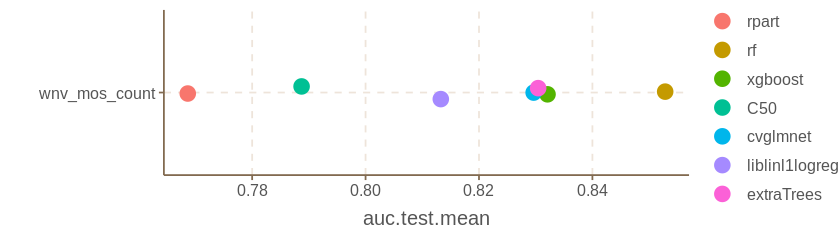

In [31]:
options(repr.plot.width=7, repr.plot.height=2)
plotBMRSummary(bmr)

Warning message:
“New theme missing the following elements: panel.grid, plot.tag, plot.tag.position”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”

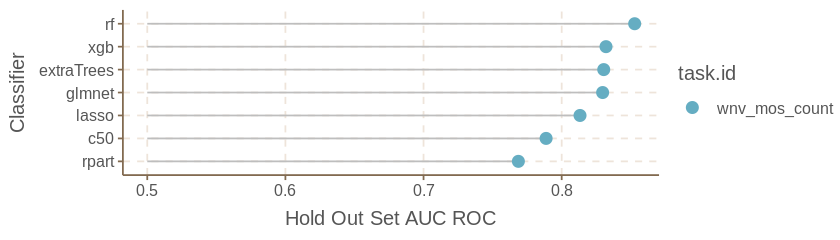

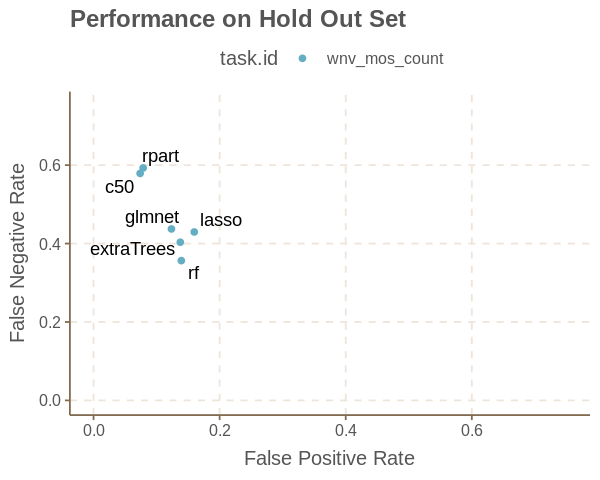

In [32]:
options(repr.plot.width=7, repr.plot.height=2)
getBMRAggrPerformances(bmr,as.df = T) %>%
    select(task.id, learner.id, auc.test.mean) %>%
    mutate(learner.id = forcats::fct_reorder(learner.id,auc.test.mean,.desc = F)) %>%
    ggplot(aes(learner.id, auc.test.mean))+
    geom_segment(aes(xend=learner.id,yend=0.5),color="gray")+
    geom_point(aes(color=task.id),size=3)+
    coord_flip()+
    labs(y="Hold Out Set AUC ROC",x="Classifier")

library("ggrepel")
ggthemr("fresh")
options(repr.plot.width=5, repr.plot.height=4)
getBMRAggrPerformances(bmr, as.df = T) %>%
    select(task.id, learner.id,fpr.test.mean,fnr.test.mean) %>%
    #bind_rows(list(learner.id="logistic_reg",fpr.test.mean=.119,fnr.test.mean=.078),
    #         list(learner.id="lda",fpr.test.mean=0.168,fnr.test.mean=.008),
    #         list(learner.id="neg_binomial",fpr.test.mean=0.121,fnr.test.mean=.087))%>%
    ggplot(aes(x=fpr.test.mean, y=fnr.test.mean)) +
    geom_point(aes(color=task.id))+
    geom_text_repel(aes(label=learner.id),force = 6,segment.colour = "#65ADC2")+
    theme(legend.position = "top")+
    scale_y_continuous(limits = c(0,.75))+
    scale_x_continuous(limits = c(0,.75))+
    labs(x="False Positive Rate", y="False Negative Rate", title = "Performance on Hold Out Set")

In [33]:
df = generateThreshVsPerfData(bmr, measures = list(fpr, tpr, mmce),task.id = "wnv_mos_count")

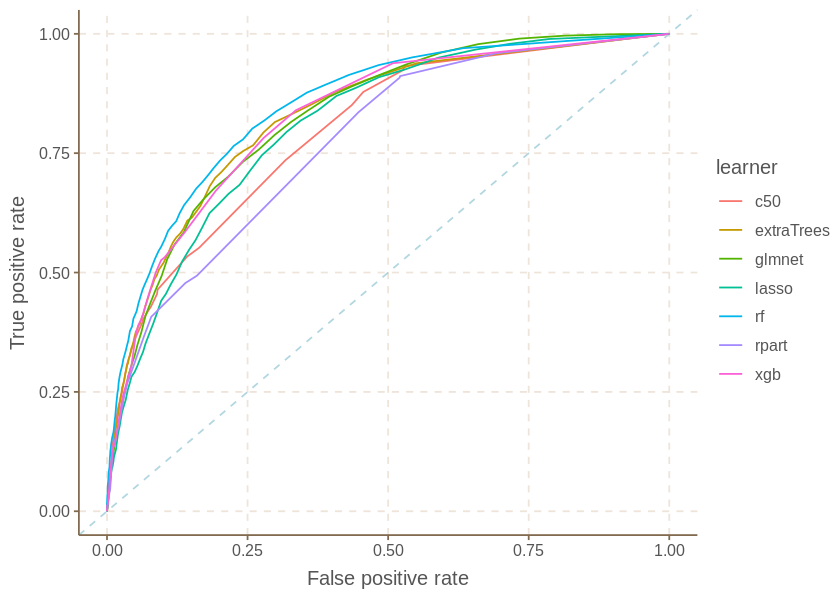

In [34]:
options(repr.plot.width=7, repr.plot.height=5)
plotROCCurves(df)

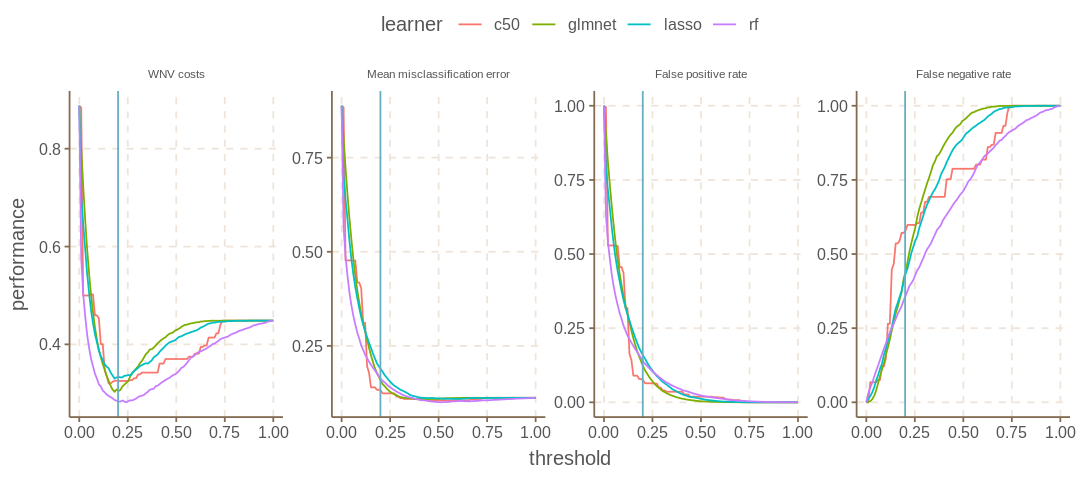

In [35]:
d = generateThreshVsPerfData(bmr$results$wnv_mos_count[c("rf","lasso","c50","glmnet")], 
                             measures = list(wnv.costs, mmce, fpr, fnr))
options(repr.plot.width=9, repr.plot.height=4)
plotThreshVsPerf(d, mark.th = th, facet.wrap.nrow = 1) +
    theme(strip.text.x = element_text(size = 7), legend.position = "top")

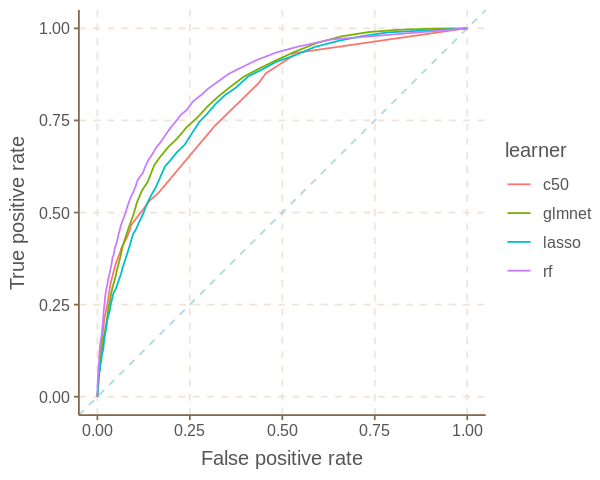

In [36]:
options(repr.plot.width=5, repr.plot.height=4)
generateThreshVsPerfData(bmr$results$wnv_mos_count[c("lasso","c50","glmnet","rf")], 
                         measures = list(fpr, tpr, mmce),task.id = "wnv_mos_count") %>%
    plotROCCurves()

saveRDS(object = bmr, file = "bmr_001.RData")

# Tuning

## Tune Random Forest

Without tuning, the baseline result...

In [37]:
preds = getBMRPredictions(bmr,task.ids = "wnv_mos_count", learner.ids = "rf",drop = T)

In [38]:
calculateROCMeasures(preds)

          predicted
true       Clean     Infected                      
  Clean    8852      1432      tpr: 0.64 fnr: 0.36 
  Infected 463       836       fpr: 0.14 tnr: 0.86 
           ppv: 0.37 for: 0.05 lrp: 4.62 acc: 0.84 
           fdr: 0.63 npv: 0.95 lrm: 0.41 dor: 11.16


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [39]:
ctrl = makeTuneControlGrid(tune.threshold = FALSE)
ctrl

Tune control: TuneControlGrid
Same resampling instance: TRUE
Imputation value: <worst>
Start: <NULL>

Tune threshold: FALSE
Further arguments: resolution=10

In [40]:
getLearnerParamSet(lrn_list[[2]])

                     Type  len   Def   Constr Req Tunable Trafo
ntree             integer    -   500 1 to Inf   -    TRUE     -
mtry              integer    -     - 1 to Inf   -    TRUE     -
replace           logical    -  TRUE        -   -    TRUE     -
classwt     numericvector <NA>     - 0 to Inf   -    TRUE     -
cutoff      numericvector <NA>     -   0 to 1   -    TRUE     -
strata            untyped    -     -        -   -   FALSE     -
sampsize    integervector <NA>     - 1 to Inf   -    TRUE     -
nodesize          integer    -     1 1 to Inf   -    TRUE     -
maxnodes          integer    -     - 1 to Inf   -    TRUE     -
importance        logical    - FALSE        -   -    TRUE     -
localImp          logical    - FALSE        -   -    TRUE     -
proximity         logical    - FALSE        -   -   FALSE     -
oob.prox          logical    -     -        -   Y   FALSE     -
norm.votes        logical    -  TRUE        -   -   FALSE     -
do.trace          logical    - FALSE    

In [41]:
ps = makeParamSet(
    makeDiscreteParam("ntree", values = c(150,300)),
    makeDiscreteParam("mtry", values = c(20,50,70,100)),
    makeLogicalParam("replace",tunable = T))
ps

            Type len Def       Constr Req Tunable Trafo
ntree   discrete   -   -      150,300   -    TRUE     -
mtry    discrete   -   - 20,50,70,100   -    TRUE     -
replace  logical   -   -            -   -    TRUE     -

In [42]:
(lrn_rf = makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th))

Learner rf from package randomForest
Type: classif
Name: Random Forest; Short name: rf
Class: classif.randomForest
Properties: twoclass,multiclass,numerics,factors,ordered,prob,class.weights,oobpreds,featimp
Predict-Type: prob
Hyperparameters: 


In [43]:
parallelStartSocket(cpus = 39)
res_rf = tuneParams(learner = lrn_rf, measures = meas, 
                 task = tsk_mos_count, 
                 resampling = rdesc,  
                 par.set = ps, 
                 control = ctrl)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
[Tune] Started tuning learner rf for parameter set:
            Type len Def       Constr Req Tunable Trafo
ntree   discrete   -   -      150,300   -    TRUE     -
mtry    discrete   -   - 20,50,70,100   -    TRUE     -
replace  logical   -   -            -   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0Imputation value: 1Imputation value: -0Imputation value: -0Imputation value: 1Imputation value: 1Imputation value: -0Imputation value: 4
Exporting objects to slaves for mode socket: .mlr.slave.options
Mapping in parallel: mode = socket; cpus = 39; elements = 16.
[Tune] Result: ntree=300; mtry=20; replace=TRUE : auc.test.mean=0.8493063,mmce.test.mean=0.1664508,f1.test.mean=0.4615085,tpr.test.mean=0.6358737,fpr.test.mean=0.1414819,fnr.test.mean=0.3641263,ppv.test.mean=0.3622225,wnv.costs.test.mean=0.2889580
Stopped parallelization. All cleaned up.


parallelStartSocket(cpus = 39)

rdesc_cv = makeResampleDesc("CV", iters = 3, stratify = TRUE)

meas = list(auc, mmce, f1, tpr, fpr, fnr, kappa, ppv)

lrn_rf = makeLearner(cl = "classif.randomForest", predict.type = "prob")
#res = tuneParams(learner = lrn_rf, task = tsk_mos_count, resampling = rdesc_cv, par.set = ps, control = ctrl, measures = meas,show.info = TRUE)

lrn_wrap = makeTuneWrapper(learner = lrn_rf, par.set = ps, control = ctrl, resampling = rdesc_cv)

res = resample(learner = lrn_wrap, task = tsk_mos_count, resampling = rdesc_cv, measures = meas, extract = getTuneResult, show.info = TRUE)

#r = resample(lrn_wrap, tsk_mos_count, rdesc_cv, extract = getTuneResult)
parallelStop()

In [44]:
res_df = generateHyperParsEffectData(res_rf,partial.dep = T)[[1]]
res_df$ntree = as.factor(res_df$ntree)
res_df

ntree,mtry,replace,auc.test.mean,mmce.test.mean,f1.test.mean,tpr.test.mean,fpr.test.mean,fnr.test.mean,ppv.test.mean,wnv.costs.test.mean,iteration,exec.time
150,20,TRUE,0.8491071,0.1658465,0.4651252,0.6428022,0.1416764,0.3571978,0.3644228,0.2860226,1,58.391
300,20,TRUE,0.8493063,0.1664508,0.4615085,0.6358737,0.1414819,0.3641263,0.3622225,0.2889580,2,99.316
150,50,TRUE,0.8427213,0.1709402,0.4590451,0.6466513,0.1478996,0.3533487,0.3558472,0.2898213,3,66.486
300,50,TRUE,0.8451761,0.1680912,0.4661489,0.6543495,0.1456632,0.3456505,0.3620455,0.2843823,4,111.753
150,70,TRUE,0.8447651,0.1699905,0.4613396,0.6489607,0.1471217,0.3510393,0.3579129,0.2880946,5,73.915
300,70,TRUE,0.8454237,0.1684365,0.4650300,0.6528099,0.1458576,0.3471901,0.3611995,0.2852456,6,117.066
150,100,TRUE,0.8421313,0.1717172,0.4608638,0.6543495,0.1497472,0.3456505,0.3557552,0.2880083,7,80.949
300,100,TRUE,0.8439685,0.1704222,0.4615318,0.6512702,0.1478996,0.3487298,0.3574828,0.2877493,8,129.400
150,20,FALSE,0.8459436,0.1642925,0.4653113,0.6374134,0.1392454,0.3625866,0.3664301,0.2862816,9,56.613
300,20,FALSE,0.8472237,0.1636018,0.4678225,0.6412625,0.1389537,0.3587375,0.3682499,0.2842960,10,100.925


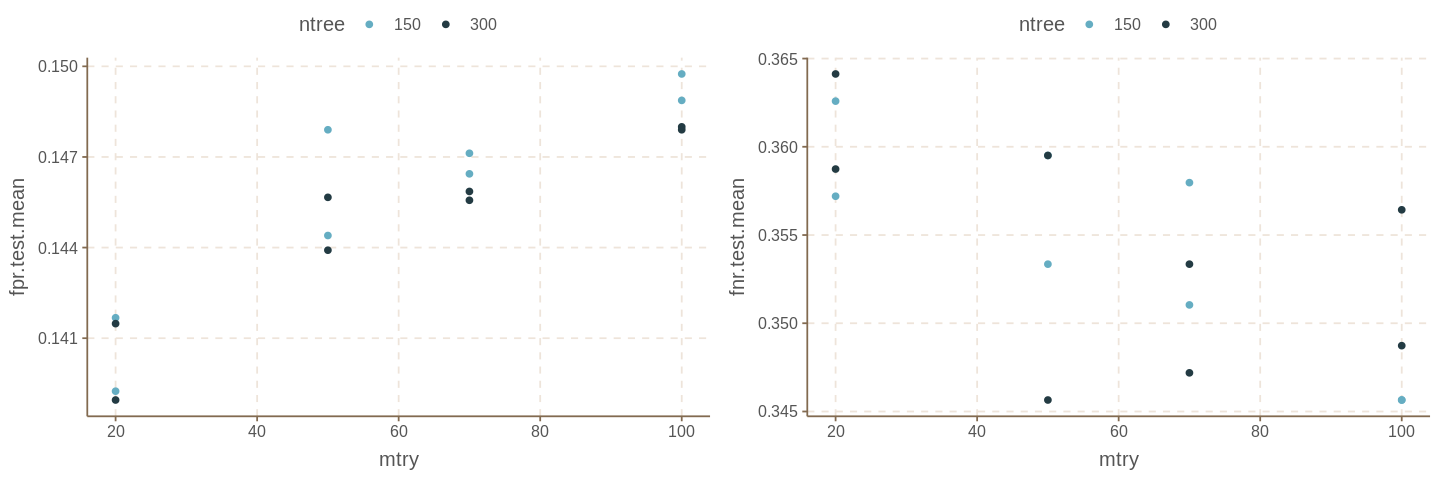

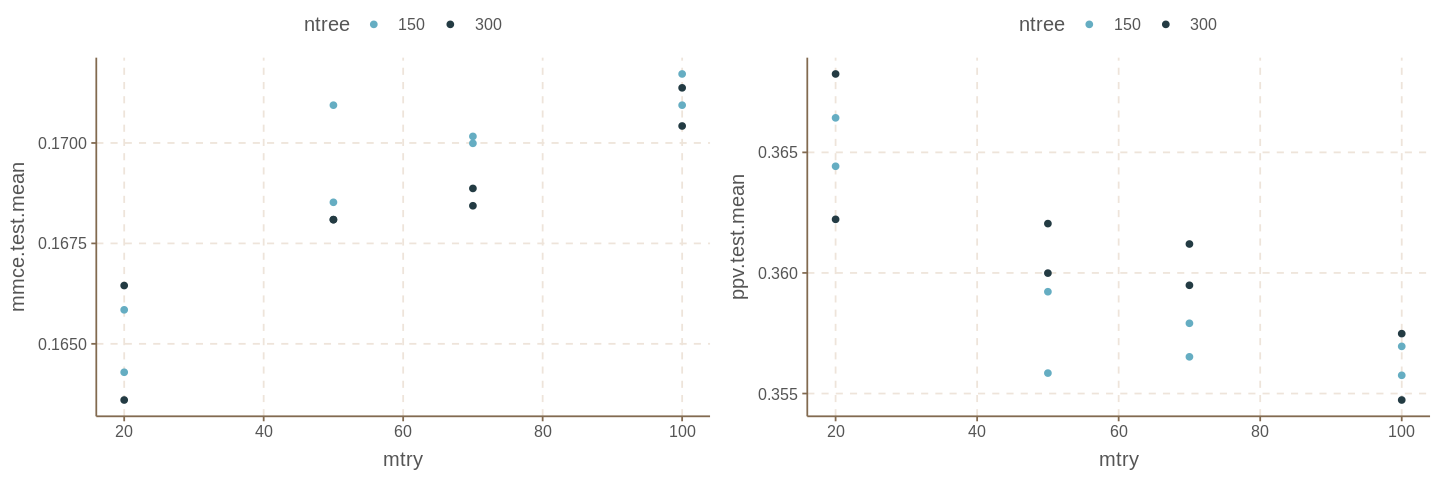

In [45]:
options(repr.plot.width=12, repr.plot.height=4)
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = fpr.test.mean, color = ntree)) +
    theme(legend.position = "top")-> p1
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = fnr.test.mean, color = ntree)) +
    theme(legend.position = "top") -> p2
cowplot::plot_grid(p1,p2)
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = mmce.test.mean, color = ntree)) +
    theme(legend.position = "top")-> p1
res_df%>%
    ggplot()+
    geom_point(aes(x=mtry, y = ppv.test.mean, color = ntree)) +
    theme(legend.position = "top") -> p2
cowplot::plot_grid(p1,p2)

In [46]:
parallelStartSocket(cpus = 39)
lrn_rf = setHyperPars(makeLearner(id = "rf", cl = "classif.randomForest", predict.type = "prob", predict.threshold = th), 
                      par.vals = res_rf$x)
r = resample(learner = lrn_rf, task = tsk_mos_count, resampling = rdesc, measures = meas)
pred = getRRPredictions(r)
calculateROCMeasures(pred)
parallelStop()

Starting parallelization in mode=socket with cpus=39.
Exporting objects to slaves for mode socket: .mlr.slave.options
Resampling: cross-validation
Measures:             auc         mmce        f1          tpr         fpr         fnr         ppv         wnv.costs   
Mapping in parallel: mode = socket; cpus = 39; elements = 3.


Aggregated Result: auc.test.mean=0.8584999,mmce.test.mean=0.1652422,f1.test.mean=0.4695611,tpr.test.mean=0.6520400,fpr.test.mean=0.1421626,fnr.test.mean=0.3479600,ppv.test.mean=0.3669349,wnv.costs.test.mean=0.2823103




          predicted
true       Clean     Infected                      
  Clean    8822      1462      tpr: 0.65 fnr: 0.35 
  Infected 452       847       fpr: 0.14 tnr: 0.86 
           ppv: 0.37 for: 0.05 lrp: 4.59 acc: 0.83 
           fdr: 0.63 npv: 0.95 lrm: 0.41 dor: 11.31


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

Stopped parallelization. All cleaned up.


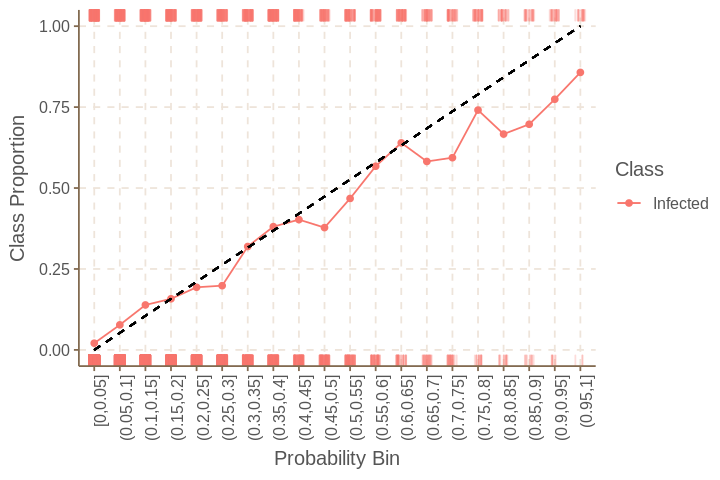

In [47]:
options(repr.plot.width=6, repr.plot.height=4)
cal = generateCalibrationData(pred)
plotCalibration(cal, smooth = F)

In [48]:
setThreshold(pred, threshold = .5) %>% calculateROCMeasures

          predicted
true       Clean     Infected                       
  Clean    10035     249       tpr: 0.29  fnr: 0.71 
  Infected 916       383       fpr: 0.02  tnr: 0.98 
           ppv: 0.61 for: 0.08 lrp: 12.18 acc: 0.9  
           fdr: 0.39 npv: 0.92 lrm: 0.72  dor: 16.85


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

In [49]:
setThreshold(pred, threshold = th) %>% calculateROCMeasures

          predicted
true       Clean     Infected                      
  Clean    8823      1461      tpr: 0.65 fnr: 0.35 
  Infected 453       846       fpr: 0.14 tnr: 0.86 
           ppv: 0.37 for: 0.05 lrp: 4.58 acc: 0.83 
           fdr: 0.63 npv: 0.95 lrm: 0.41 dor: 11.28


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio

## Tune GLMNet

What parameters can be tuned for a glmnet model?

glmnet_ps = makeParamSet(
      makeNumericParam("alpha", lower = 0, upper = 1)
)

ctrl = makeTuneControlRandom(maxit = 20L)

lrn_glmnet = makeLearner(id = "glmnet", cl = "classif.cvglmnet", predict.type = "prob", predict.threshold = th)

parallelStartSocket(cpus = 39)
res = tuneParams(learner = lrn_glmnet, measures = meas, 
                 task = tsk_mos_count, 
                 resampling = rdesc,  
                 par.set = glmnet_ps, 
                 control = ctrl)
parallelStop()

res

res_df = generateHyperParsEffectData(res,partial.dep = T)[[1]]
res_df